In [1]:
from functools import partial

import numpy as np
import PIL
import matplotlib.pyplot as plt
import trimesh
from trimesh import Scene

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\bobla\anaconda3\envs\pytorch_cuda\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:

mesh = trimesh.load("../models/bunny.ply")

# Normalize the mesh using trimesh functionality
mesh.apply_translation(-mesh.centroid)
scale_factor = 1.0 / mesh.extents.max()
mesh.apply_scale(scale_factor)


<trimesh.Trimesh(vertices.shape=(8146, 3), faces.shape=(16301, 3))>

In [4]:

def get_transformed_scene(mesh, rotation_transform, translation_vector) -> Scene:
    transformed = mesh.copy()
    transformed.apply_transform(rotation_transform)
    # transformed.apply_translation(translation_vector)
    # tt = transformed.apply_obb()  # i guess it works..
    scene = Scene()
    scene.add_geometry(transformed, geom_name="mesh") #, transform=transformation_matrix)
    scene.apply_translation(translation_vector)
    scene.camera.resolution = [640, 480]
    # set field of view, in degrees
    # make it relative to resolution so pixels per degree is same
    scene.camera.fov = [
        60,
        60,
    ]  # * (scene.camera.resolution / scene.camera.resolution.max())
    return scene

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*[0, 0, 0]), [0, 0, 0])
origin, vectors, pixels = scene.camera_rays()


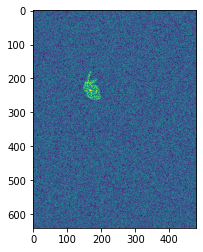

In [19]:

def raytrace_silhouette(scene, perc=0.5, inds=None):
    if perc == 1:
        origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), vectors.shape)
        hits = scene.geometry["mesh"].ray.intersects_any(ray_origins=origin, ray_directions=vectors)
        return hits.reshape(scene.camera.resolution)[:, ::-1].astype(np.uint8) + 1

    w, h = scene.camera.resolution
    if inds is None:
        inds = np.random.choice(w*h, int(w*h*perc), False)

    origin = np.broadcast_to(trimesh.transformations.translation_from_matrix(scene.camera_transform), (inds.shape[0], 3))
    # run the mesh- ray test
    hits = scene.geometry["mesh"].ray.intersects_any(ray_origins=origin, ray_directions=vectors[inds])

    # find pixel locations of actual hits
    sub_pixels = pixels[inds]
    pixel_ray = sub_pixels[hits]

    # create a numpy array we can turn into an image
    # doing it with uint8 creates an `L` mode greyscale image
    a = np.zeros(scene.camera.resolution, dtype=np.uint8)
    a[sub_pixels[:, 0], sub_pixels[:, 1]] = 1
    a[pixel_ray[:, 0], pixel_ray[:, 1]] = 2
    return a

sil = raytrace_silhouette(scene, perc=0.6)

plt.imshow(sil)

In [14]:
# %%timeit
sil = raytrace_silhouette(scene, perc=0.6)
# 50.6 ms ± 1.99 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

In [15]:
## jacaards index for comparing two incomplete masks:
def stochastic_jacaard_index(m1: np.ndarray, m2: np.ndarray):
    """Where 2 means positive, 1 means negative, and 0 means not measured/unknown, I / U should only consider knowns"""
    m1_pos = m1 == 2
    m2_pos = m2 == 2
    m1_neg = m1 == 1
    m2_neg = m2 == 1
    count_agree_pos = (m1_pos & m2_pos).sum()  # intersection
    count_pos = (m1_pos & m2_neg).sum() + (m1_neg & m2_pos).sum() + count_agree_pos
    if count_pos == 0:
        return 0
    return count_agree_pos / count_pos

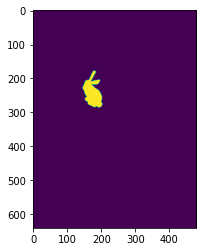

In [20]:
true_rotation = np.array([1, 0, 1])  # np.random.rand(3) * 2 * np.pi
true_translation = np.array([1, 1, 5])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*true_rotation), true_translation)
true_sil = raytrace_silhouette(scene, perc=1)

plt.imshow(true_sil == 2)

0.21604486710558402


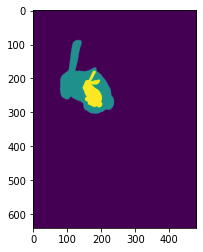

In [38]:

rotation = true_rotation + np.array([.6, .1, .2])
translation = true_translation + np.array([-.5, -.5, -4])

scene = get_transformed_scene(mesh, trimesh.transformations.euler_matrix(*rotation), translation)
sil = raytrace_silhouette(scene, perc=1)

print(stochastic_jacaard_index(true_sil, sil))
  
plt.imshow(sil + true_sil)

In [39]:
def get_scene_from_theta(theta: np.ndarray):
    # theta is rotation matrix, and translation matrix
    rotation = theta[:3]
    translation = theta[3:]
    rotation_matrix = trimesh.transformations.euler_matrix(*rotation)
    return get_transformed_scene(mesh, rotation_matrix, translation)

def get_loss_from_sil(sil):
    js = stochastic_jacaard_index(true_sil, sil)
    js = np.clip(js, 0.00001, 0.99999)
    log_odds = np.log(1 - js) - np.log(js)
    return log_odds

def get_loss_from_theta(theta: np.ndarray, perc=0.5, inds=None):
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=perc, inds=inds)
    return get_loss_from_sil(sil)

theta_0 = np.append(rotation, translation)
get_loss_from_theta(theta_0)


1.2773854245196408

In [22]:
theta_opt = np.append(true_rotation, true_translation)
get_loss_from_theta(theta_opt)

-11.51291546492478

In [44]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values


def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb


def optim_spsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1):
    theta = theta_0
    P = len(theta)
    k = 0
    for k, perturb in enumerate(bernouli_sample(P)):
        ak = ak_gen(k)
        ck = ck_gen(k)
        grad = approx_gradient(loss_fnc, perturb, theta, ck)
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta

optim = optim_spsa(np.array(theta_0), get_loss_from_theta, ak_gain, ck_gain)

In [45]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_theta(theta)}")

0: 1.2393098507982492
10: 1.1353894164858347
20: 1.0923852659992894
30: 0.9061140502120076
40: 0.8289171016655666
50: 0.7308664166136183
60: 0.6894259797580915
70: 0.6775499837462774
80: 0.585739581280394
90: 0.5920510636885765


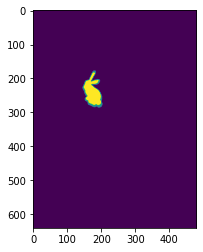

In [25]:
scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)
plt.imshow(sil + true_sil)

In [48]:
fig, ax = plt.subplots()

theta = np.array(theta_0)
optim = optim_spsa(np.array(theta), partial(get_loss_from_theta, perc=1), ak_gain, ck_gain)

scene = get_scene_from_theta(theta)
sil = raytrace_silhouette(scene, perc=1)

img = ax.imshow(sil + true_sil)
plt.close()
# This function updates the y-data of the line for each frame
def update(i):
    theta = next(optim)
    scene = get_scene_from_theta(theta)
    sil = raytrace_silhouette(scene, perc=1)
    if i % 10 == 0:
        print(f"{i}: {get_loss_from_sil(sil)}")
    
    img.set_data(sil + true_sil)
    return img

ani = FuncAnimation(fig, update, frames=range(200), blit=False, interval=100)
HTML(ani.to_jshtml())

0: 1.2589163358182351
0: 1.2481126436912071
10: 1.1199166465818384
20: 1.0185538472102045
30: 0.9066992963131384
40: 0.8619390560435767
50: 0.8001069832484793
60: 0.7665270562491746
70: 0.7013964095326221
80: 0.5938696034603671
90: 0.40840558924040116
100: 0.3772364427049183
110: 0.30132484885556743
120: 0.26136180379846863
130: 0.21341900142221504
140: 0.18657345089115351
150: 0.13008202622389664
160: 0.07049609578995675
170: 0.031229737706869765
180: 0.02429506293660566
190: 0.017884232256420884
